In [1]:
!pip install scenedetect docarray[hnswlib] pillow torch torchvision matplotlib opencv-python-headless
!pip install git+https://github.com/facebookresearch/ImageBind.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.0/122.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.2/270.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached

In [8]:
import os
import cv2
from glob import glob
from IPython.display import Image, display, HTML

import torch
import pandas as pd
from typing import List, Tuple
from dataclasses import dataclass
from docarray import DocList, BaseDoc
from docarray.documents import TextDoc, ImageDoc
from docarray.typing import NdArray
from docarray.index import HnswDocumentIndex

from imagebind import data as ibdata
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType
from scenedetect import detect, ContentDetector, SceneManager, VideoManager

In [3]:
VIDEO_PATH = '/content/videoplayback.mp4'  # Replace with your video path
SCENES_FOLDER = 'video_scenes'
BATCH_SIZE = 2000

In [10]:
@dataclass
class SceneInfo:
    scene_path: str
    start_time: float
    end_time: float
    start_frame: int
    end_frame: int

class SceneDoc(BaseDoc):
    scene_path: str
    start_time: float
    end_time: float
    start_frame: int
    end_frame: int
    embedding: NdArray[1024]

In [13]:
class VideoSceneSearch:
    def __init__(self, video_path: str, scenes_folder: str):
        self.video_path = video_path
        self.scenes_folder = scenes_folder
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self._load_model()
        self.doc_index = None

    def _load_model(self):
        model = imagebind_model.imagebind_huge(pretrained=True)
        return model.eval().to(self.device)

    def embed(self, doc):
        with torch.no_grad():
            if isinstance(doc, TextDoc):
                modality_type, transform_func = (ModalityType.TEXT, ibdata.load_and_transform_text)
                input_data = [doc.text]
            elif isinstance(doc, ImageDoc):
                modality_type, transform_func = (ModalityType.VISION, ibdata.load_and_transform_vision_data)
                input_data = [doc.url]
            else:
                raise ValueError('Unsupported document type')

            inputs = transform_func(input_data, self.device)
            embedding = self.model({modality_type: inputs})[modality_type]
            doc.embedding = embedding.cpu().numpy()[0]
        return doc

    def extract_scenes(self) -> List[SceneInfo]:
        os.makedirs(self.scenes_folder, exist_ok=True)

        video = cv2.VideoCapture(self.video_path)
        fps = video.get(cv2.CAP_PROP_FPS)

        scene_list = detect(self.video_path, ContentDetector())

        scenes_info = []
        for i, scene in enumerate(scene_list):
            start_frame = scene[0].frame_num
            end_frame = scene[1].frame_num
            start_time = start_frame / fps
            end_time = end_frame / fps

            video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
            ret, frame = video.read()
            if ret:
                frame_path = os.path.join(self.scenes_folder, f"scene_{i:04d}.jpg")
                cv2.imwrite(frame_path, frame)

                scenes_info.append(SceneInfo(frame_path, start_time, end_time, start_frame, end_frame))

        video.release()
        print(f"Saved {len(scenes_info)} scene frames to {self.scenes_folder}")
        return scenes_info

    def process_scenes(self, scenes_info: List[SceneInfo]) -> pd.DataFrame:
        data = pd.DataFrame(scenes_info)
        data['embedding'] = data['scene_path'].apply(lambda path: self.embed(ImageDoc(url=path)).embedding)
        return data

    def index_scenes(self, data: pd.DataFrame):
        self.doc_index = HnswDocumentIndex[SceneDoc](work_dir='/store')

        for i in range(0, len(data), BATCH_SIZE):
            batch = data.iloc[i:i+BATCH_SIZE]
            docs = DocList[SceneDoc](
                SceneDoc(**row.to_dict())
                for _, row in batch.iterrows()
            )
            self.doc_index.index(docs)

        print(f"Indexed {len(data)} scenes in total.")

    def search(self, query, limit: int = 5) -> List[Tuple[SceneDoc, float]]:
        if isinstance(query, str):
            query_embedding = self.embed(TextDoc(text=query)).embedding
        elif isinstance(query, ImageDoc):
            query_embedding = self.embed(query).embedding
        else:
            raise ValueError("Query must be either a string or an ImageDoc")

        matches = self.doc_index.find(query_embedding, search_field='embedding', limit=limit)
        return [(match, score) for match, score in zip(matches.documents, matches.scores)]

    def display_results(self, results: List[Tuple[SceneDoc, float]]):
        for match, score in results:
            display(Image(filename=match.scene_path))
            display(HTML(f"""
                <b>Scene: {os.path.basename(match.scene_path)}</b><br>
                Start Time: {match.start_time:.2f}s<br>
                End Time: {match.end_time:.2f}s<br>
                Start Frame: {match.start_frame}<br>
                End Frame: {match.end_frame}<br>
                Similarity Score: {score:.4f}
            """))


In [14]:
searcher = VideoSceneSearch(VIDEO_PATH, SCENES_FOLDER)
scenes_info = searcher.extract_scenes()
data = searcher.process_scenes(scenes_info)
data.to_json('embedded_video_scenes.json')
searcher.index_scenes(data)

INFO:pyscenedetect:Downscale factor set to 2, effective resolution: 320 x 180
INFO:pyscenedetect:Detecting scenes...


Saved 135 scene frames to video_scenes
Indexed 135 scenes in total.


Text Search Results:


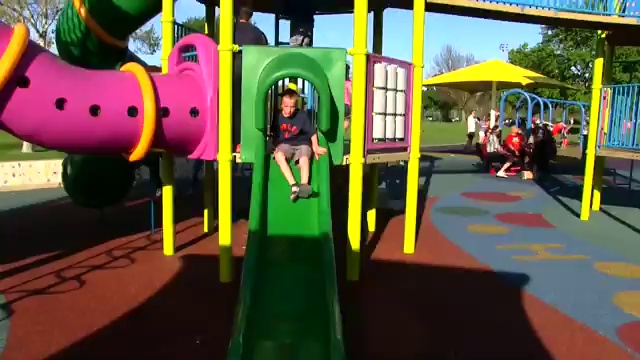

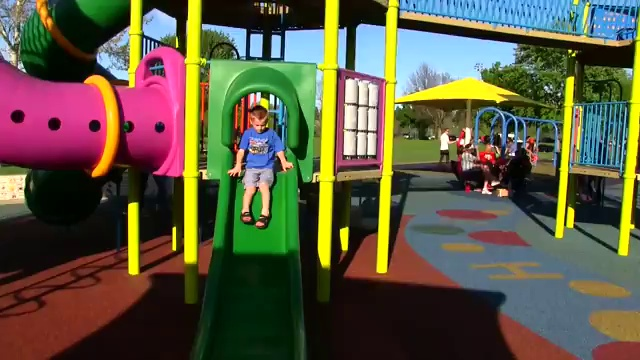

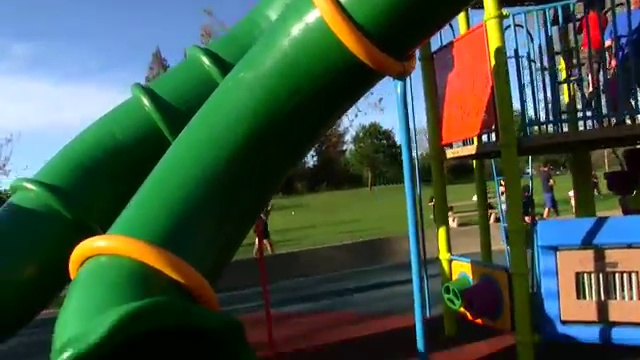

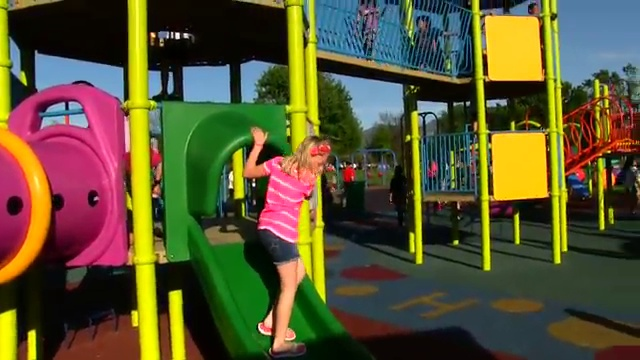

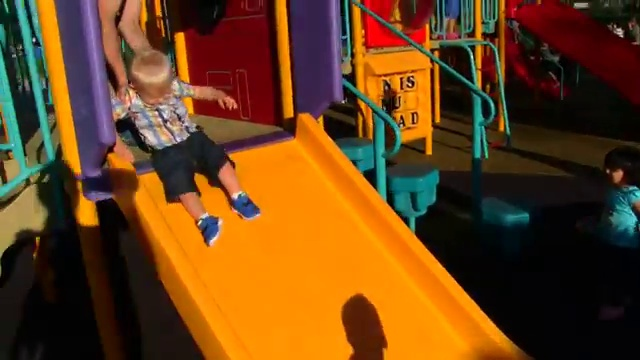

In [15]:
# Example: Search using text
text_query = 'child on a green slide'
text_results = searcher.search(text_query)
print("Text Search Results:")
searcher.display_results(text_results)

# Example: Search using image
# image_query = ImageDoc(url='/path/to/query/image.jpg')
# image_results = searcher.search(image_query)
# print("Image Search Results:")
# searcher.display_results(image_results)